# Procesamiento
Vamos a utilizar sklearn para el procesamiento de datos mediante pipelines.
- Buena info de cómo hacer esto aquí: https://www.youtube.com/watch?v=0B5eIE_1vpU&t=1227s

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)

train = pd.read_csv('data/train_data.csv')
test = pd.read_csv('data/test_data.csv')

In [2]:
# Vamos a definir los datos de entrenamiento
X = train.drop(['mineralType', 'id'], axis=1)
y = train['mineralType']

<AxesSubplot:>

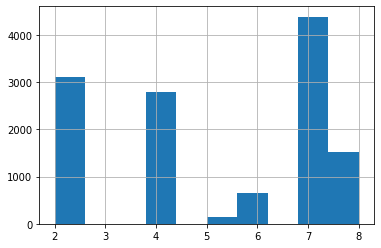

In [3]:
train['climaticZone'].hist()

In [35]:
train['climaticZone'].value_counts()

7    4386
2    3116
4    2798
8    1522
6     652
5     146
3       1
Name: climaticZone, dtype: int64

Fitting 5 folds for each of 24 candidates, totalling 120 fits


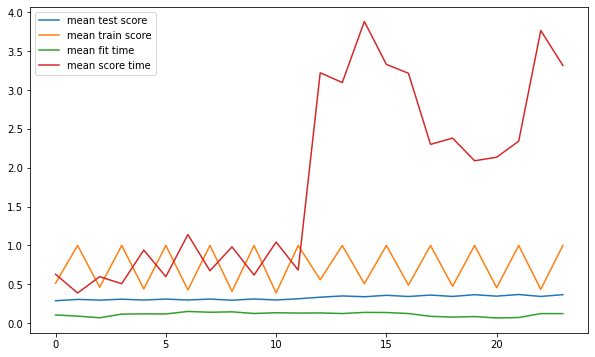

In [46]:
# Create sklearn pipeline for data preprocessing
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, make_scorer, f1_score
import numpy as np

preprocessor = ColumnTransformer([
        # (name, transformer, columns)
        ("temperatureFirstHalfPlanetRotation", FunctionTransformer(lambda f: (f - 32) / 1.8, feature_names_out="one-to-one"), ['temperatureFirstHalfPlanetRotation']), # convert from Fahrenheit to Celsius
        ("temperatureSecondHalfPlanetRotation", "passthrough", ['temperatureSecondHalfPlanetRotation']), # pass through the column unchanged
        ("waterStreamDistanceX", FunctionTransformer(lambda f: f * 0.3048, feature_names_out="one-to-one"), ['waterStreamDistanceX']), # convert from feet to meters
        ("waterStreamDistanceY", "passthrough", ['waterStreamDistanceY']), # pass through the column unchanged
        ("planetSection", OneHotEncoder(handle_unknown = "ignore"), ['planetSection']), # one-hot encode the planetSection column
        ("cover", OneHotEncoder(handle_unknown='error', drop='first'), ['cover']), # one-hot encode the cover column and drop the first column (the one with the missing values == 0)
        ("climaticZone", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1), ['climaticZone']), # ordinal encode the climaticZone column TODO: drop category 3? what to do? only one row has a 3
        ("geoZone", OneHotEncoder(handle_unknown = "ignore"), ['geoZone']), # one-hot encode the geoZone column TODO: drop category 5?
        ("rockSize", OneHotEncoder(handle_unknown='ignore', drop='first'), ['rockSize']), # one-hot encode the rockSize column and drop the first column (the one with the missing values == 0)
        ("magmaConcentrationDistance", OneHotEncoder(handle_unknown = "ignore"), ['magmaConcentrationDistance']), # one-hot encode the rockSize column and drop the first column (the one with the missing values == 0) TODO: use Ordinal Encoder?
        ("mineralDensity", "passthrough", ['mineralDensity']), # pass through the column unchanged
        ("detectionDepth", "passthrough", ['detectionDepth']), # pass through the column unchanged TODO: convert km to m?
        ("longitude", "passthrough", ['longitude']), # pass through the column unchanged TODO: values > 360? do x - 360
    ],
    verbose_feature_names_out=False, remainder='drop'
)

model = KNeighborsClassifier()

pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('model', model)
])

grid = GridSearchCV(pipe, cv=5, scoring=make_scorer(accuracy_score), error_score='raise', return_train_score=True, n_jobs=-1, verbose=1,
            param_grid={
                'model__n_neighbors': [5, 8, 10, 12, 15, 20],
                'model__weights': ['uniform', 'distance'],
                'model__metric': ['euclidean', 'manhattan']
            })
grid.fit(X, y).score(X, y)

# Plot the results of the grid search to see which parameters are the best for the model to use
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(grid.cv_results_['mean_test_score'], label='mean test score')
plt.plot(grid.cv_results_['mean_train_score'], label='mean train score')
plt.plot(grid.cv_results_['mean_fit_time'], label='mean fit time')
plt.plot(grid.cv_results_['mean_score_time'], label='mean score time')
plt.legend()
plt.show()


In [48]:
pd.DataFrame(grid.cv_results_).sort_values(by='rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__metric,param_model__n_neighbors,param_model__weights,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
21,0.072180,0.005051,2.342308,0.409962,manhattan,15,distance,"{'model__metric': 'manhattan', 'model__n_neigh...",0.356436,0.372029,0.369651,0.371632,0.371632,0.368276,0.005978,1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
23,0.122444,0.013220,3.317390,0.784334,manhattan,20,distance,"{'model__metric': 'manhattan', 'model__n_neigh...",0.359604,0.370840,0.360935,0.364897,0.374010,0.366057,0.005574,2,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
19,0.084636,0.023485,2.089987,0.272728,manhattan,12,distance,"{'model__metric': 'manhattan', 'model__n_neigh...",0.361584,0.364897,0.370048,0.362520,0.370048,0.365819,0.003617,3,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
17,0.087476,0.007333,2.300954,0.083609,manhattan,10,distance,"{'model__metric': 'manhattan', 'model__n_neigh...",0.350891,0.361727,0.367670,0.364897,0.360935,0.361224,0.005695,4,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
15,0.136416,0.011841,3.330204,0.203993,manhattan,8,distance,"{'model__metric': 'manhattan', 'model__n_neigh...",0.348515,0.357765,0.366878,0.359746,0.357369,0.358055,0.005870,5,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
13,0.123421,0.013259,3.096756,0.313587,manhattan,5,distance,"{'model__metric': 'manhattan', 'model__n_neigh...",0.344554,0.356181,0.351823,0.349842,0.346672,0.349814,0.004052,6,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
20,0.066293,0.002466,2.135600,0.039301,manhattan,15,uniform,"{'model__metric': 'manhattan', 'model__n_neigh...",0.340990,0.354596,0.349049,0.346276,0.345483,0.347279,0.004482,7,0.459192,0.457661,0.453699,0.457958,0.452412,0.456184,0.002637
22,0.122374,0.023662,3.767053,0.876697,manhattan,20,uniform,"{'model__metric': 'manhattan', 'model__n_neigh...",0.340594,0.346672,0.344295,0.341918,0.344295,0.343555,0.002110,8,0.439580,0.434684,0.431613,0.434089,0.432109,0.434415,0.002829
18,0.077400,0.008382,2.381740,0.161524,manhattan,12,uniform,"{'model__metric': 'manhattan', 'model__n_neigh...",0.337030,0.351426,0.342314,0.344295,0.341918,0.343396,0.004673,9,0.481775,0.468951,0.471526,0.470239,0.472715,0.473041,0.004545
16,0.123576,0.023093,3.216262,0.316432,manhattan,10,uniform,"{'model__metric': 'manhattan', 'model__n_neigh...",0.344158,0.338352,0.342710,0.347464,0.341125,0.342762,0.003040,10,0.495741,0.489155,0.488561,0.485491,0.483510,0.488492,0.004167


In [6]:
preprocessed_data = preprocessor.fit_transform(X)

preprocessed_dataframe = pd.DataFrame(preprocessed_data, columns=preprocessor.get_feature_names_out())
preprocessed_dataframe

,temperatureFirstHalfPlanetRotation,temperatureSecondHalfPlanetRotation,waterStreamDistanceX,waterStreamDistanceY,planetSection_Hyrule,planetSection_Mordor,planetSection_Tatoooine,cover_1,cover_2,cover_3,cover_4,geoZone_1,geoZone_2,geoZone_5,geoZone_7,rockSize_1,rockSize_2,rockSize_3,magmaConcentrationDistance_CLOSE,magmaConcentrationDistance_FAR,magmaConcentrationDistance_MEDIUM,magmaConcentrationDistance_VERY_CLOSE,magmaConcentrationDistance_VERY_FAR,mineralDensity,detectionDepth,longitude
0,-572.777778,28.9,261.426960,16.76,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,4617.64,27.49,71.86
1,39.444444,36.8,31.479744,12.13,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,9859.22,27.30,360.78
2,44.388889,33.0,31.315152,1.90,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-999.00,32.25,37.66
3,42.444444,25.5,41.269920,11.89,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,-999.00,22.35,134.36
4,44.222222,29.5,0.000000,0.00,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3991.21,23.19,109.15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12616,35.888889,21.4,42.022776,9.94,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,10576.29,33.30,105.95
12617,43.777778,37.9,272.716752,40.10,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,6457.13,28.76,330.01
12618,43.611111,33.4,355.034088,20.10,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-999.00,31.89,29.92
12619,41.222222,36.8,1086.255384,211.54,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,10078.16,32.61,358.35


In [7]:
from sklearn import set_config

set_config(display='diagram')
grid

GridSearchCV(cv=3, error_score='raise',
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('temperatureFirstHalfPlanetRotation',
                                                                         FunctionTransformer(feature_names_out='one-to-one',
                                                                                             func=<function <lambda> at 0x7f8a1883add0>),
                                                                         ['temperatureFirstHalfPlanetRotation']),
                                                                        ('temperatureSecondHalfPlanetRotation',
                                                                         'passthrough',
                                                                         ['temperatureSe...
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['magmaConcentrationDistance']),
                                                                        ('mineralDensity',
                                                                         'passthrough',
                                                                         ['mineralDensity']),
                                                                        ('detectionDepth',
                                                                         'passthrough',
                                                                         ['detectionDepth']),
                                                                        ('longitude',
                                                                         'passthrough',
                                                                         ['longitude'])],
                                                          verbose_feature_names_out=False)),
                                       ('model', KNeighborsClassifier())]),
             param_grid={'model__n_neighbors': [5]},
             scoring=make_scorer(accuracy_score))